# Modeling Rentability

**Notebook by: Emmanuel Contreras-Campana, Ph.D.**

We are now ready to model inventory trends for our client company. The main focus here will be to explore different machine learning algorithms to predict item performance based on item type, brand, size, and rental price. The reason we are restricted to only these features is that lenders will only be providing this information.

## Load Libraries

In [1]:
# Import common python library
from collections import OrderedDict

# Import numpy library
import numpy as np

# Import matplotlib library
import matplotlib.pyplot as plt

from matplotlib.pyplot import *
from matplotlib import colors

# Import pandas library
import pandas as pd

# Import scikit-learn library
from sklearn.externals import joblib

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder, 
                                   OneHotEncoder)

from sklearn.metrics import precision_recall_curve

# Import imbalance-learn library
from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import RandomOverSampler

# Import user created library
from code import *

# random seed
seed = 42

% matplotlib inline

## Load Data

We first load the data produced during the previous stages that will serve as our training and test data.

In [2]:
# load items
X = pd.read_csv(filepath_or_buffer='data/X.csv', sep=',',
                header='infer', index_col=0)

# load orders
y = pd.read_csv(filepath_or_buffer='data/y.csv', sep=',',
                header='infer', index_col=0, 
                dtype={'rental_category': 'int'})['rental_category']

In [3]:
X.head()

,size,rental_price,brand_1.state,brand_2015,brand_2016,brand_2017,brand_2b.rych,brand_3.1 phillip lim,brand_360 sweater,brand_4.collective,...,brand_zoë,brand_zuhair murad,item_type_bottoms,item_type_dresses,item_type_outerwear,item_type_pants,item_type_rompers,item_type_shirts,item_type_skirts,item_type_tops
0,4.0,60.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.0,66.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2.0,37.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,6.0,70.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.0,35.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Standardize Features

The rental price and item size will be standardized for all models even though some may not need this additional transformation. The benefit of this is that, for example, regression coefficients in Logistic Regression may be compared to each other to gain additional insight into the data that may prove to be useful.

In [4]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

## Additional Training and Test Data

Additional datsets are created from X and y but are only meant to be used for precision vs recall plots, learning curve plots, and overfitting plots. They will not be used for hyper-parameter optimization.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(),
                                                    test_size=0.33333333333,
                                                    random_state=42)

In [6]:
# Produce standardized features

sns = scaler.fit(X_train[['rental_price', 'size']])

X_train[['rental_price', 'size']] = \
  pd.DataFrame(scaler.transform(X_train[['rental_price', 'size']]),
               columns=['rental_price', 'size'], index=X_train.index)

X_test[['rental_price', 'size']] = \
  pd.DataFrame(scaler.transform(X_test[['rental_price', 'size']]),
               columns=['rental_price', 'size'], index=X_test.index)

These datasets will be stored to be used again in the model evaluation step.

In [7]:
X_train.to_csv(path_or_buf='data/X_train.csv', sep=',', header=True,
               index=True, index_label=None, mode='w',
               line_terminator='\n')

X_test.to_csv(path_or_buf='data/X_test.csv', sep=',', header=True,
              index=True, index_label=None, mode='w',
              line_terminator='\n')

y_train.to_csv(path='data/y_train.csv', sep=',', header=True,
               index=True, index_label=None, mode='w')

y_test.to_csv(path='data/y_test.csv', sep=',', header=True,
               index=True, index_label=None, mode='w')

## Modeling of Inventory Performance

We explore several machine learning models that are inherently multi-class classifiers. Models that are interpretible are preferred and use the others as a sanity check.

The high and moderate performing inventory samples are highly imblanced with respect to the low preforming inventory so care must be taken. This is accomplished by oversampling the minority class to match that of the majority class. In essence, we will be using bootstrap sampling. The hyper-paramerters will be optimized and cross-validated using the Logarithmic Loss function (i.e. log loss). Log loss heavily penalizes any strongly mis-classified prediction and for this reason it was chosen. Precision and Recall are used for the model selection and evaluation. Those values are also cross-validated for robustness.

Stratified k-fold cross validation is used over regular k-fold cross-validation due to the class imbalances. And to reduce computation time we only employ 3-fold cross-validation.

In [8]:
## Stratified K-Fold cross-validation
k_fold = 3

outer_kfold_cv = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=seed)
inner_kfold_cv = StratifiedKFold(n_splits=k_fold-1, shuffle=True, random_state=seed)

## Random Over Sampling of minority class
ros = RandomOverSampler(ratio='all', random_state=1)

### Dummy Classification

Dummy classification will serve as our baseline model. The classifier will make random predictions on the test dataset based on what it found the class composition to be in the training sample. If the training data had 60% low performing inventory, 30% moderate performing inventory, and 10% high performing inventory then it will make predictions based on these porportions on the test dataset irrepective of what the actual features are of the samples.

In [9]:
## Fitting a dummy model (baseline model)

# Dummy classifier model
# options:  'most_frequent', 'stratified'
dc = DummyClassifier(strategy='stratified', random_state=1)

# Fit model
dc.fit(X_train, y_train)

# Persist model
joblib.dump(dc, 'models/DummyClassifier.pkl');

In [10]:
# Load model
dc = joblib.load('models/DummyClassifier.pkl')

# E### Dummy Classificationvaluate model performance with accuracy
summary_report(dc, X_test, X_train, y_test, y_train)

Accuracy score on train data: 0.7223454052722346
Accuracy score on test data: 0.7192118226600985 

Precision score on train data: [0.8426143 0.0795107 0.096875 ]
Precision score on test data: [0.84952607 0.06896552 0.08333333] 

Recall score on train data: [0.84015196 0.08201893 0.096875  ]
Recall score on test data: [0.8322693  0.07741935 0.09210526] 

Log loss on train data: 9.589849962321837
Log loss on test data: 9.698080071477385


The dummy classifier does not generalize well to the test dataset. Its precsion (i.e. about 8%) and recall (i.e. 8%) values are very low and it has a large log loss value.

Therefore, we would like to know if other machine learning algorithms can peform better than the baseline model.

### Logistic Regression

Our first attempt is with a linear model like Logistic Regression. We investigate different regularization parameters and use the one that performs the best.

In [12]:
## Fitting a logistic regression model with ridge regression

# Hyper-parameter space
name = 'LogisticRegression'.lower()

param_grid = {name+'__C': [0.1, 1, 10]}

# Losgistic regression model
log = LogisticRegression(penalty='l2', C=0.1, 
                         solver='sag', #'liblinear', #'lbfgs', #'sag',
                         max_iter=1000, n_jobs=-1,
                         tol= 1e-3,
                         class_weight=None,
                         multi_class='multinomial')

pipe = make_pipeline(ros, scaler, log)

# Hyper-parameter optimization and model evaluation using nested cross-validation
log = grid_search(pipe, X, y,
                  outer_kfold_cv, inner_kfold_cv,
                  param_grid, scoring='neg_log_loss',
                  debug=True)

# Persist model
joblib.dump(log, 'models/LogisticRegression.pkl');

fold- 1 model fitting...

	 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.001, verbose=0, warm_start=False)

	Model validation score: 1.0421772463526358 

	 (array([0.88845781, 0.12359551, 0.18025751]), array([0.53411079, 0.41772152, 0.53164557]), array([0.66715222, 0.19075145, 0.26923077]), array([1715,  158,  158]))
fold- 2 model fitting...

	 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.001, verbose=0, warm_start=False)

	Model validation score: 1.0468237040153483 

	 (array([0.89507299, 0.13076923, 0.21065375]), array([0.57201166, 0.43312102, 0.55414013]), array([0.69797225, 0.20088626, 0.30526316]), array([1715

['models/LogisticRegression.pkl']

The Final model evaluation is 1.0460312393222424 (i.e. the log loss).

The presion for the low, moderate, high performing inventory is given by [0.88978235, 0.12006542, 0.18723259], which are cross-validated values. Similarly for the recall, [0.5617104 , 0.38764815, 0.52328738].

In [9]:
# Load model
log = joblib.load('models/LogisticRegression.pkl')

# Evaluate model performance
log.fit(X_train, y_train)

summary_report(log, X_test, X_train, y_test, y_train)

Accuracy score on train data: 0.5954668637595467
Accuracy score on test data: 0.5349753694581281 

Precision score on train data: [0.96419692 0.21169176 0.26006529]
Precision score on test data: [0.90425532 0.11645102 0.19340659] 

Recall score on train data: [0.5666277  0.75394322 0.746875  ]
Recall score on test data: [0.54265815 0.40645161 0.57894737] 

Log loss on train data: 0.7272988194824455
Log loss on test data: 1.0393475232681744


In [10]:
import lime
import lime.lime_tabular

In [22]:
# Use LIME to explain individual predictions, initialize explainer object
explainer = lime.lime_tabular\
                .LimeTabularExplainer(# training data
                                      training_data=X_train.values,
                                      mode='classification',
                                      # names of all features (regardless of type)
                                      feature_names=X_train.columns.tolist(),
                                      # class names
                                      class_names=[0, 1, 2], 
                                      discretize_continuous=True,
                                      categorical_features=None,
                                      categorical_names=X_train.columns[2:].tolist(),
                                      kernel_width=3)

In [23]:
predict_fn_kerasclassifier=lambda x: log.predict_proba(x).astype(float)

In [28]:
# Explain a prediction ("local interpretability"): 
exp = explainer\
     .explain_instance(# 2d numpy array, corresponding to a row
                       data_row=X_test.values[1],
                       # classifier prediction probability function, 
                       predict_fn=predict_fn_kerasclassifier,
                       # iterable with labels to be explained.
                       labels=(0, 1, 2),
                       # maximum number of features present in explanation
                       num_features=X_test.shape[1],
                       # explanations for the K labels with highest prediction 
                       # probabilities,
                       #top_labels=0,
                       # size of the neighborhood to learn the linear model
                       num_samples=X_test.shape[0]//2,
                       # the distance metric to use for weights.
                       distance_metric='euclidean'
                      )

In [ ]:
1+1

In [ ]:
exp.as_list()

In [ ]:
exp.show_in_notebook(show_table=True, 
                     show_all=False)

In [ ]:
fig = exp.as_pyplot_figure()
exp.save_to_file('lime_explanation_oi.html')

In [ ]:
print('Couples probability:', exp.predict_proba[1])

In [ ]:
# Local explanation for class 1 and 0
exp.as_pyplot_figure()

These values may be compared to the previous cross-validated precision and recall values and serves to check that everything is staying consistent.

### Gradient Boosting Classifier

For our second attempt, we choose a non-linear model that could in essence capture any interaction terms between features the data may have.

In [14]:
## Fitting Dummy Classification

# Hyper-parameter space
name = 'GradientBoostingClassifier'.lower()

param_grid = {name+'__'+'learning_rate': [0.1, 0.2],
              name+'__'+'n_estimators': [5, 10, 15],
              name+'__'+'max_depth': [None, 2, 5]}

# Extra tree classifier model
gbc = GradientBoostingClassifier()

pipe = make_pipeline(ros, scaler, gbc)

# Hyper-parameter optimization and model evaluation using nested cross-validation
gbc = grid_search(pipe, X, y,
                  outer_kfold_cv, inner_kfold_cv,
                  param_grid, scoring='neg_log_loss',
                  debug=True)

# Persist model
joblib.dump(gbc, 'models/GradientBoostingClassifier.pkl');

fold- 1 model fitting...

	 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

	Model validation score: 0.6992382200179065 

	 (array([0.87818878, 0.13080169, 0.2300885 ]), array([0.80291545, 0.19620253, 0.32911392]), array([0.83886689, 0.15696203, 0.27083333]), array([1715,  158,  158]))
fold- 2 model fitting...

	 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
          

['models/GradientBoostingClassifier.pkl']

In [15]:
# Load model
gbc = joblib.load('models/GradientBoostingClassifier.pkl')

# Evaluate model performance with accuracy
gbc.fit(X_train, y_train)

summary_report(gbc, X_test, X_train, y_test, y_train)

Accuracy score on train data: 0.9465385562946539
Accuracy score on test data: 0.7108374384236453 

Precision score on train data: [0.99968915 0.78589421 0.70561798]
Precision score on test data: [0.88728702 0.15030675 0.2247191 ] 

Recall score on train data: [0.93980129 0.98422713 0.98125   ]
Recall score on test data: [0.78583865 0.31612903 0.26315789] 

Log loss on train data: 0.30345131416606214
Log loss on test data: 0.7098383037276653


### Random Forest Classifier

Another non-linear model we can use is random forrest which differs from gradient boosted decesion trees in that the former produces trees that are statistically independent.

In [16]:
## Fitting Random forest classifier

# Hyper-parameter space
name = 'RandomForestClassifier'.lower()

param_grid = {name+'__'+'n_estimators': [5, 10, 15, 20, 25, 50],
              name+'__'+'max_depth': [None, 2, 5],
              name+'__'+'min_samples_leaf': [1, 2, 3]}

# Hyper-parameter optimization and model evaluation using nested cross-validation
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

pipe = make_pipeline(ros, scaler, rfc)

# Random forest classifier model
rfc = grid_search(pipe, X, y, 
                  outer_kfold_cv, inner_kfold_cv,
                  param_grid, scoring='neg_log_loss',
                  debug=True)

# Persist model
joblib.dump(rfc, 'models/RandomForestClassifier.pkl');

fold- 1 model fitting...

	 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

	Model validation score: 0.829039719565703 

	 (array([0.88122333, 0.13842482, 0.26213592]), array([0.72244898, 0.36708861, 0.34177215]), array([0.79397629, 0.20103986, 0.2967033 ]), array([1715,  158,  158]))
fold- 2 model fitting...

	 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_j

In [17]:
# Load model
rfc = joblib.load('models/RandomForestClassifier.pkl')

# Evaluate model performance with accuracy
rfc.fit(X_train, y_train)

summary_report(rfc, X_test, X_train, y_test, y_train)

Accuracy score on train data: 0.8388765705838876
Accuracy score on test data: 0.6896551724137931 

Precision score on train data: [0.98029727 0.41209564 0.60659341]
Precision score on test data: [0.89088398 0.14173228 0.27860697] 

Recall score on train data: [0.82875511 0.92429022 0.8625    ]
Recall score on test data: [0.74869414 0.3483871  0.36842105] 

Log loss on train data: 0.6599628849035342
Log loss on test data: 0.8238379198456196


Random forest and gradient boosting are performing relatively the same.

### K Neighbors Classifier

In [24]:
## Fitting a K-Neighbors classifier

# Hyper-parameter space
name = 'KNeighborsClassifier'.lower()

param_grid = {name+'__n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20, 30],
              name+'__weights': ['uniform', 'distance']}

# Hyper-parameter optimization and model evaluation using nested cross-validation
knn = KNeighborsClassifier(n_jobs=-1)

pipe = make_pipeline(ros, scaler, knn)

# K-Neighbors classifier model
knn = grid_search(pipe, X, y, 
                  outer_kfold_cv, inner_kfold_cv,
                  param_grid, scoring='neg_log_loss',
                  debug=True)

# Persist model
joblib.dump(knn, 'models/KNeighborsClassifier.pkl');

fold- 1 model fitting...

	 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
           weights='uniform')

	Model validation score: 2.0357848478584377 

	 (array([0.88514357, 0.10641026, 0.17555556]), array([0.41341108, 0.52531646, 0.5       ]), array([0.563593  , 0.17697228, 0.25986842]), array([1715,  158,  158]))
fold- 2 model fitting...

	 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
           weights='uniform')

	Model validation score: 2.126020524162379 

	 (array([0.88860104, 0.10953058, 0.16606498]), array([0.4       , 0.49044586, 0.58598726]), array([0.55166868, 0.17906977, 0.25879044]), array([1715,  157,  157]))
fold- 3 model fitting...

	 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
           weights='unifo

In [25]:
# Load model
knn = joblib.load('models/KNeighborsClassifier.pkl')

# Evaluate model performance with accuracy
knn.fit(X_train, y_train)

summary_report(knn, X_test, X_train, y_test, y_train)

Accuracy score on train data: 0.5304262133530426
Accuracy score on test data: 0.470935960591133 

Precision score on train data: [0.94798658 0.18015873 0.22848665]
Precision score on test data: [0.88631347 0.11287758 0.16565657] 

Recall score on train data: [0.49532437 0.71608833 0.721875  ]
Recall score on test data: [0.46604759 0.45806452 0.53947368] 

Log loss on train data: 0.8849811163319387
Log loss on test data: 1.9854619177581976


### Support Vector Machine

In [37]:
## Fitting a Support vector classifier

# Hyper-parameter space
name = 'SVC'.lower()

param_grid = {name+'__C': [0.5, 1, 5, 10]}

# Support vector machine model
svm = SVC(probability=True)

pipe = make_pipeline(ros, scaler, svm)

# Hyper-parameter optimization and model evaluation using nested cross-validation
svm = grid_search(pipe, X, y,
                  outer_kfold_cv, inner_kfold_cv,
                  param_grid, scoring='neg_log_loss',
                  debug=True)

# Persist model
joblib.dump(svm, 'models/SVC.pkl');

fold- 1 model fitting...

	 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

	Model validation score: 0.9928097846976068 

	 (array([0.89651294, 0.11494253, 0.18161435]), array([0.46472303, 0.50632911, 0.51265823]), array([0.61213518, 0.18735363, 0.26821192]), array([1715,  158,  158]))
fold- 2 model fitting...

	 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

	Model validation score: 0.9663312806011257 

	 (array([0.89442231, 0.11783439, 0.20151134]), array([0.52361516, 0.47133758, 0.50955414]), array([0.66053696, 0.18853503, 0.28880866]), array([1715,  157,  157]))
fold- 3 model fitting...

	 SVC(C=10, cache_size=200, class_weight=None, c

['models/SVC.pkl']

In [38]:
# Load model
svm = joblib.load('models/SVC.pkl')

# Evaluate model performance with accuracy
svm.fit(X_train, y_train)

summary_report(svm, X_test, X_train, y_test, y_train)

Accuracy score on train data: 0.5954668637595467
Accuracy score on test data: 0.45123152709359604 

Precision score on train data: [0.9697733  0.21349274 0.26799557]
Precision score on test data: [0.90658683 0.11072056 0.15335463] 

Recall score on train data: [0.56253653 0.78864353 0.75625   ]
Recall score on test data: [0.43934997 0.40645161 0.63157895] 

Log loss on train data: 0.8291612340780092
Log loss on test data: 0.9967554584849927


## Overfitting plots

Once the models have been trained and hyper-parameters optimized, we can explore how well they model the data. For example, is the probability distribution for high performing inventory items modeled well between test and training data in the case of the signal and background samples seperately.

### Dummy Classifier

Using stored model file


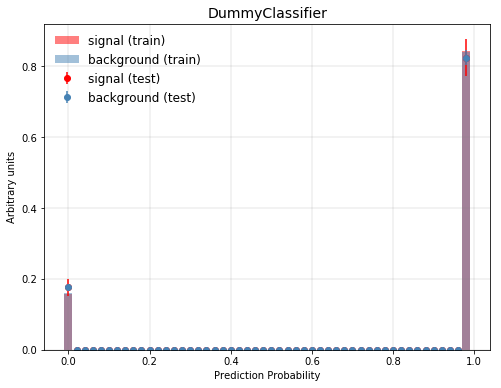

None

Using stored model file


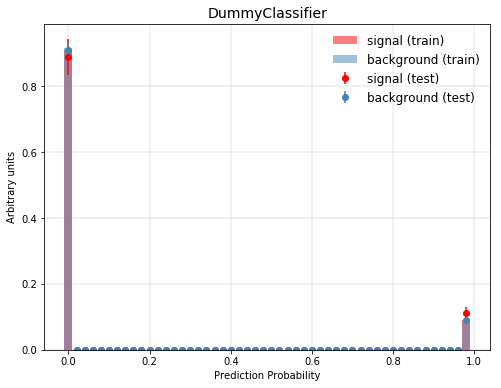

None

Using stored model file


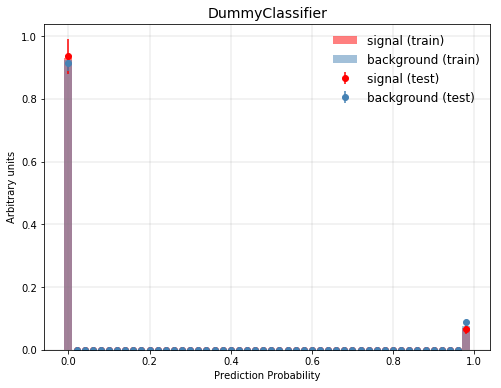

None

In [32]:
# Plot overfitting
plot_overfitting(dc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='models')

plot_overfitting(dc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='models')
### Support Vector Machine
plot_overfitting(dc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='models')

In the plots above, the solid blue histograms represent the probability distribution for the background training data while the solid red histograms are for the signal training data. The blue and red dots are for the test data. In the first plot, the signal is the low performing inventory while the moderate and high performing inventory are considered background. In the second plot, the signal is the moderate performing inventory and in the last the signal is the high performing inventory. 

### Logistic Regression Classifier

Using stored model file


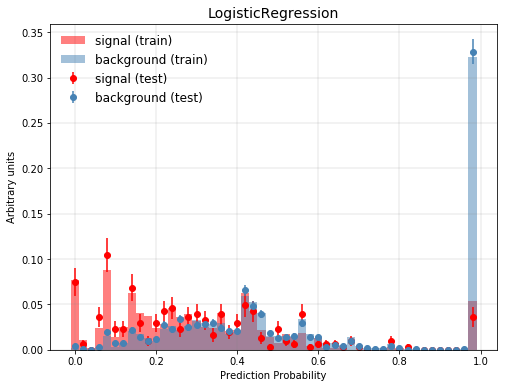

None

Using stored model file


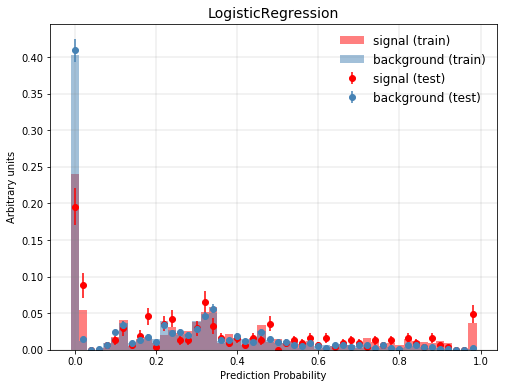

None

Using stored model file


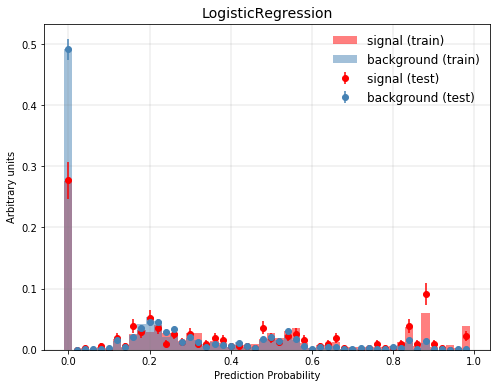

None

In [33]:
# Plot overffiting
plot_overfitting(log, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='models')

plot_overfitting(log, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='models')

plot_overfitting(log, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='models')

We observed that there that the model is not being overtrained on the training data as the background and signal distributions are well model, respectively. There also appears to be a discrimination between the signal and background distributions which is a good indication that the model will perform well but not necessarily. Further investigation will be needed to be sure of this.

### Gradient Boosting Classifier

Using stored model file


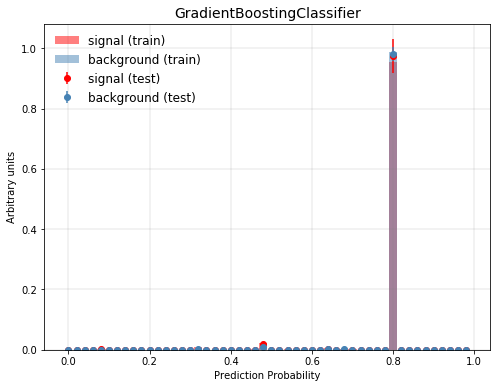

None

Using stored model file


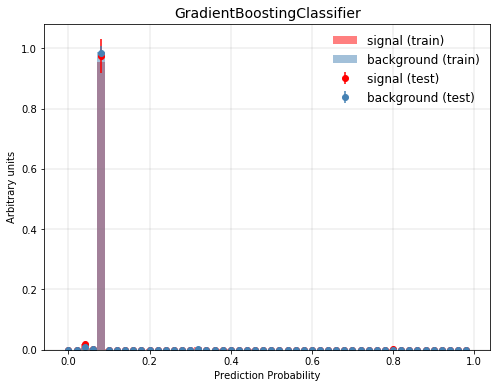

None

Using stored model file


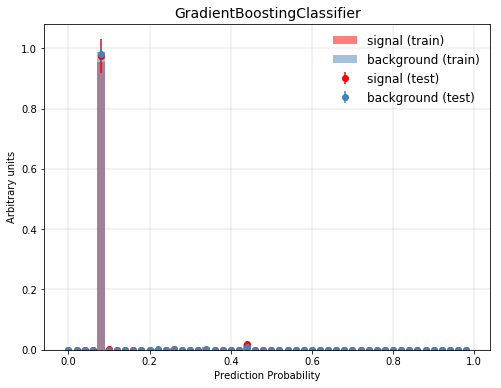

None

In [34]:
# Plot overffiting
plot_overfitting(gbc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='models')

plot_overfitting(gbc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='models')

plot_overfitting(gbc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='models')

### Random Forest Classifier

Using stored model file


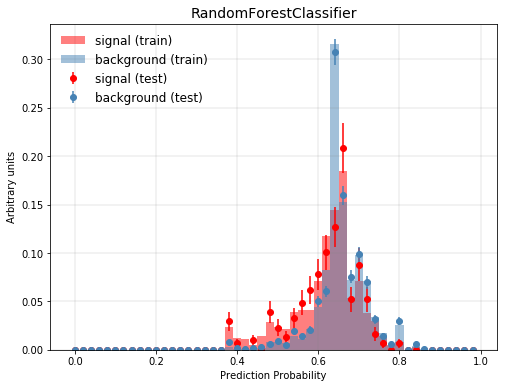

None

Using stored model file


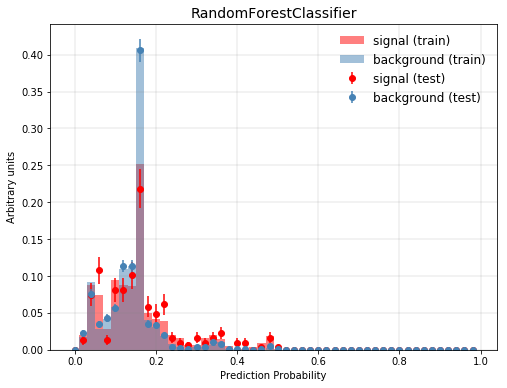

None

Using stored model file


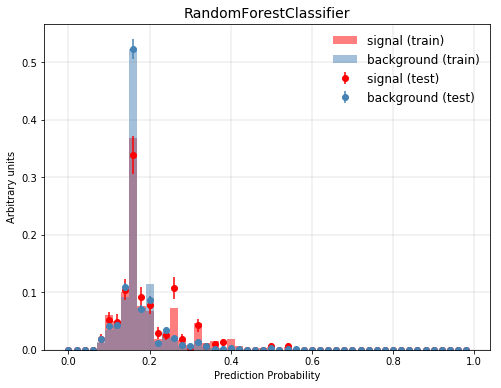

None

In [35]:
# Plot overffiting
plot_overfitting(rfc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='models')

plot_overfitting(rfc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='models')

plot_overfitting(rfc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='models')

### K-Neighbors Classifier

Using stored model file


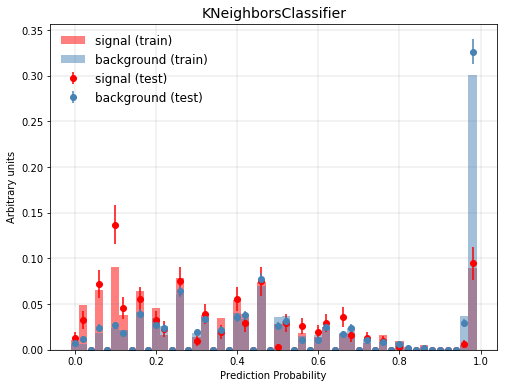

None

Using stored model file


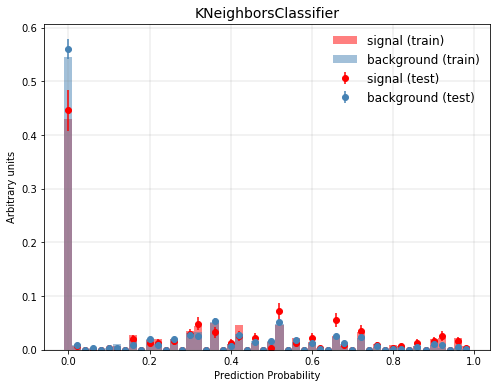

None

Using stored model file


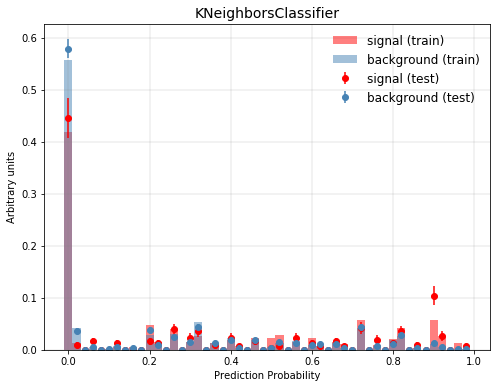

None

In [31]:
# Plot overffiting
plot_overfitting(knn, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='models')

plot_overfitting(knn, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='models')

plot_overfitting(knn, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='models')

### Support Vector Machine

Using stored model file


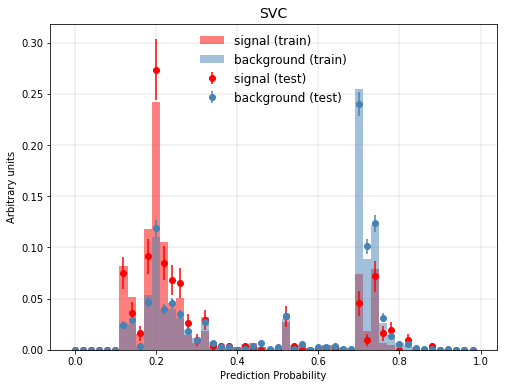

None

Using stored model file


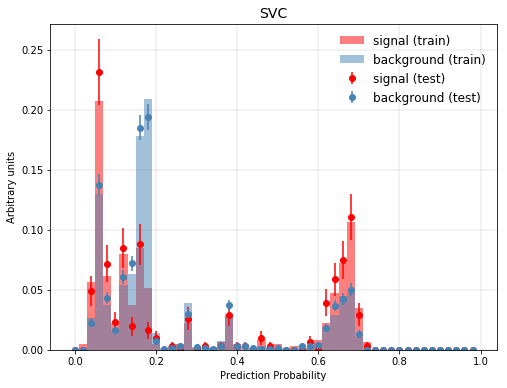

None

Using stored model file


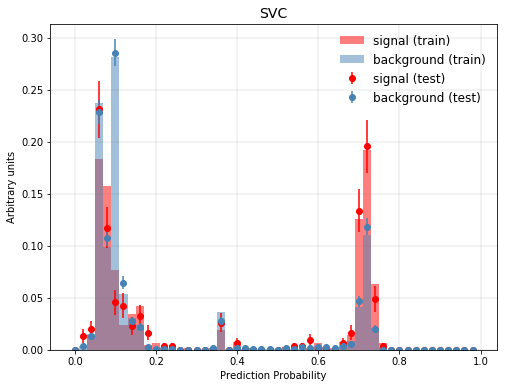

None

In [39]:
# Plot overffiting
plot_overfitting(svm, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='models')

plot_overfitting(svm, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='models')

plot_overfitting(svm, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='models')

Having used several machine learning algorithms to model the data in order to predict inventory performace we must systematically evaluate each one to select the best one. We accomplish this in the next step.

## Learning Curve

Another useful plot to look at are learning curves. These help to indicate whether a particular model is being under or over trained.

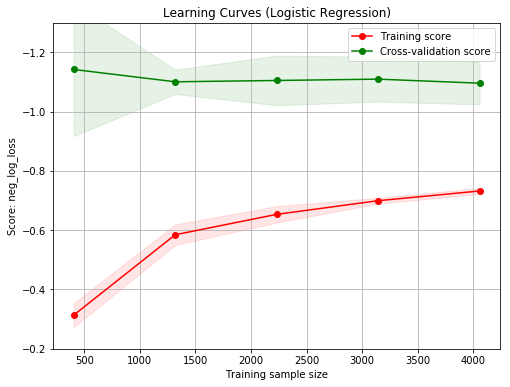

None

In [29]:
# Learning curve title
title = "Learning Curves (Logistic Regression)"

log = joblib.load('models/LogisticRegression.pkl')

pipe = make_pipeline(ros, scaler, log)

plot_learning_curve(pipe, title, X, y, ylim=(-0.20, -1.30), 
                    cv=None, scoring='neg_log_loss', n_jobs=1,
                    train_sizes=np.linspace(.1, 1.0, 5))

The plot shows that given the amount of data that is currently available our models are under trained. In the future as the company continues to rent or sell more inventory the model should show improvement in its predictions.